In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="anon", project="anon", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="anon", project="anon",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Pendulum data-efficiency
query = {"$and": [{"tags": "data-efficiency"},
                  {"tags": "submission"},
                  {"state": "finished"},
                  {"config.body_args": [2]},
                  {"config.body_class": "ChainPendulum"},
                  #{"config.n_train": {"$lte": 4000}},
                  {"config.lr": 3e-3},
                 ]}

runs, histories = zip(*get_history(query=query))

In [4]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    network_class = run.config["network_class"]
    if network_class == "NN":
        network_class = "NeuralODE"
        
    n_train = run.config["n_train"]
    #n_train = (r"$N_{train}$=", f"{n_train}")
    n_train = n_train

#     rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
#     rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pred_true = (pred_zts - true_zts).pow(2).sum((2, 3, 4)).sqrt() / (pred_zts.pow(2).sum((2,3,4)).sqrt() + true_zts.pow(2).sum((2,3,4)).sqrt()) 
    rel_err_pert_true = (pert_zts - true_zts).pow(2).sum((2, 3, 4)).sqrt() / (pert_zts.pow(2).sum((2,3,4)).sqrt() + true_zts.pow(2).sum((2,3,4)).sqrt()) 

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.cpu().numpy()
    avg_rel_err_pert = rel_err_pert_true.cpu().numpy()

    # turn into list of series from batch of series   
    series += avg_rel_err_pred.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pred", batch) for batch in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pert", batch) for batch in range(len(avg_rel_err_pert))]

In [5]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
levels = ['n_train', 'Network', "Series", "Batch"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [6]:
df.head()

,n_train,Network,Series,Batch,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,10000,CLNN,avg_rel_err_pred,0,0.000000e+00,7.569236e-07,0.000001,0.000002,4.440787e-06,0.000005,...,0.000253,0.000298,0.000346,0.000396,0.000447,0.000501,0.000557,0.000616,0.000677,0.000741
1,10000,CLNN,avg_rel_err_pred,1,0.000000e+00,2.685583e-06,0.000004,0.000005,6.101202e-06,0.000006,...,0.000028,0.000031,0.000035,0.000039,0.000041,0.000043,0.000044,0.000044,0.000042,0.000040
2,10000,CLNN,avg_rel_err_pred,2,4.058577e-09,1.473515e-06,0.000003,0.000004,6.153833e-06,0.000008,...,0.000151,0.000161,0.000173,0.000187,0.000204,0.000224,0.000248,0.000276,0.000307,0.000339
3,10000,CLNN,avg_rel_err_pred,3,3.046996e-08,1.351209e-06,0.000002,0.000003,2.766441e-06,0.000002,...,0.000041,0.000048,0.000058,0.000068,0.000078,0.000088,0.000097,0.000103,0.000106,0.000107
4,10000,CLNN,avg_rel_err_pred,4,0.000000e+00,1.147352e-06,0.000002,0.000001,4.647784e-07,0.000001,...,0.000043,0.000044,0.000043,0.000045,0.000047,0.000049,0.000050,0.000049,0.000048,0.000044


In [7]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt
n_timesteps = int(integration_time / dt)

In [8]:
df = df.rename(columns={i: dt * i for i in range(n_timesteps)})

In [9]:
df = pd.melt(df, id_vars=levels, var_name="time")

In [10]:
df = df.sort_values(by=levels)

In [11]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
colors = [(147/255,205/255,221/255), "#00058A", "#6A0078", (96/255,74/255,123/255), "#8E6100"]
sns.set_palette(sns.color_palette(colors))

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [12]:
df["n_train"].unique()

array([   10,    20,    40,    80,   100,   200,   400,   800,  1000,
        2000,  4000,  8000, 10000])

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.


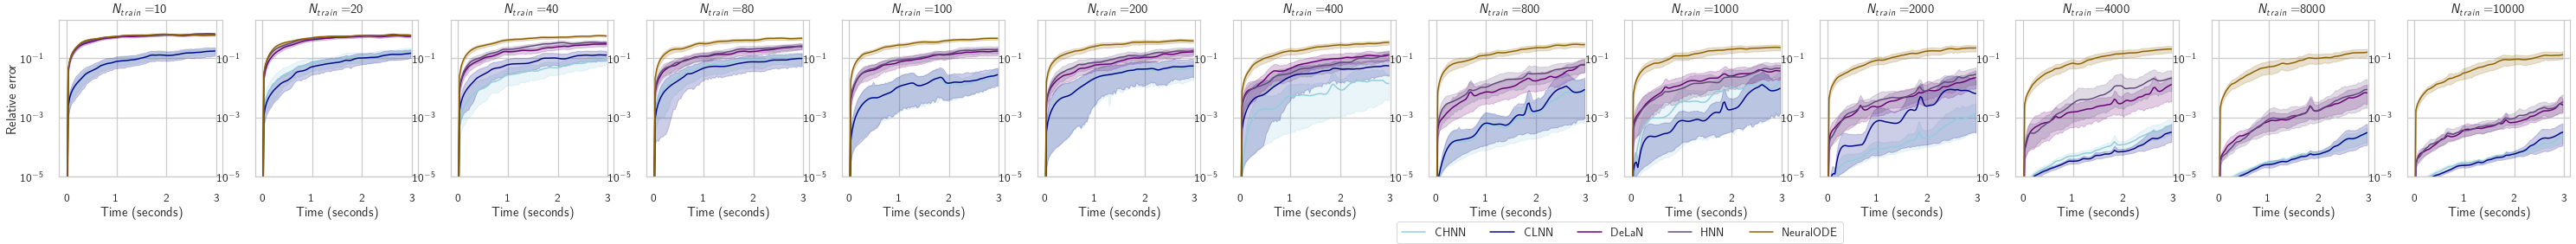

In [13]:
n_plots = len(df["n_train"].unique())
fig, axes = plt.subplots(ncols=n_plots, figsize=(4 * n_plots, 4))
for n_train, ax in zip(df["n_train"].unique(), axes):
    data = df.loc[(df["Series"] == "avg_rel_err_pred") & (df["n_train"] == n_train)]
    sns.lineplot(data=data, x="time", y="value", hue="Network", ax=ax, ci=95)
    ax.set(yscale="log", xlabel="Time (seconds)", title=r"$N_{train}=$" + f"{n_train}", ylim=(1e-5, 2))
    ax.set(ylabel="")
    ax.legend().remove()
axes[0].set(ylabel="Relative error")
handles, labels = axes[-1].get_legend_handles_labels()
labels = labels[1:] # Get rid of legend title
#fig.legend(handles, labels, loc='upper center')
fig.subplots_adjust(bottom=0.25)
fig.legend(labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [14]:
df.head()

,n_train,Network,Series,Batch,time,value
5700,10,CHNN,avg_rel_err_pert,0,0,0.000016
5900,10,CHNN,avg_rel_err_pert,0,0,0.000016
18900,10,CHNN,avg_rel_err_pert,0,0.03,0.000017
19100,10,CHNN,avg_rel_err_pert,0,0.03,0.000017
32100,10,CHNN,avg_rel_err_pert,0,0.06,0.000021


In [15]:
df_series = df.pivot_table(index=["n_train", "Network", "Series", "Batch"], columns="time", values="value")
y = df_series.to_numpy()
geom_mean = np.exp(np.trapz(np.log(y + 1e-8), dx=dt, axis=-1) / integration_time)
df_geom_mean = pd.DataFrame(index=df_series.index, data=geom_mean, columns=["Geometric Mean"])
df_geom_mean = df_geom_mean.reset_index()

In [16]:
df_geom_mean

,n_train,Network,Series,Batch,Geometric Mean
0,10,CHNN,avg_rel_err_pert,0,0.000099
1,10,CHNN,avg_rel_err_pert,1,0.000089
2,10,CHNN,avg_rel_err_pert,2,0.000036
3,10,CHNN,avg_rel_err_pert,3,0.000041
4,10,CHNN,avg_rel_err_pert,4,0.000045
...,...,...,...,...,...
12995,10000,NeuralODE,avg_rel_err_pred,95,0.006142
12996,10000,NeuralODE,avg_rel_err_pred,96,0.002025
12997,10000,NeuralODE,avg_rel_err_pred,97,0.002486
12998,10000,NeuralODE,avg_rel_err_pred,98,0.005275


In [17]:
body_args = tuple(run.config["body_args"])
if len(body_args) == 0:
    body_args = ""
elif len(body_args) == 1:
    body_args = f"{body_args[0]}-"
else:
    body_args = f"{body_args}"
    
body_class = run.config["body_class"]
if body_class == "ChainPendulum":
    body_class = "Pendulum"
body = f"{body_args}{body_class}"

In [18]:
sns.set(font_scale=1.75)
sns.set_style('whitegrid')
colors = ["#00abdf", "#00058A", "#6A0078", (96/255,74/255,123/255), "#8E6100"]
sns.set_palette(sns.color_palette(colors))

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

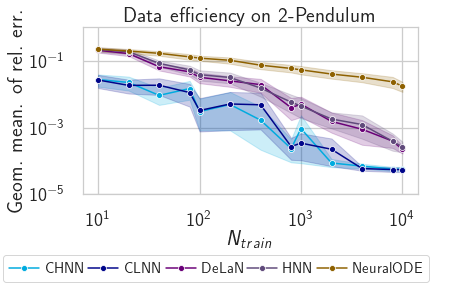

In [19]:
fig, ax = plt.subplots()
sns.lineplot(data=df_geom_mean, x="n_train", y="Geometric Mean",
             ci=95, hue="Network", ax=ax,
             markers=["o"]*df_geom_mean["Network"].nunique(),
             #markers=True,
             dashes=False,
             style="Network")
ax.set(yscale="log", ylabel="Geom. mean. of rel. err.",
       xscale="log", xlabel=r"$N_{train}$",
       title=f"Data efficiency on {body}",
       ylim=(1e-5, 1))
ax.legend().remove()
_, labels = ax.get_legend_handles_labels()
labels = labels[1:] # Remove title
fig.subplots_adjust(bottom=0.3)
fig.legend(labels=labels, bbox_to_anchor=(0, 0., 1., 0.), loc="lower center", ncol=len(labels), borderaxespad=0.2, mode="expand",
           handletextpad=0.4, prop={'size': 15})

In [20]:
df_geom_mean.to_csv("data-efficiency-pendulum.csv", index=False)

In [21]:
fig.savefig("data-efficiency.pdf", bbox_inches="tight")